In [1]:
import requests
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import PIL


import cv2
import seaborn as sns

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Helper functions for visualization:

In [2]:
# from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #fixes "squishing of plot"
    plt.ylim([1.5, -.5]) 
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

def plot_model_history(history, n_epochs):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

In [3]:
df0 = pd.read_fwf('PCC_cat.txt', header=None)
df0
# df0[21]

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,PCC-0001,49.2355,41.5722,20.51,0.04,1.44,0.10,20.80,1.07,...,0.69,0.25,0.63,0.28,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
1,NaN,PCC-0002,49.2366,41.4013,20.44,0.04,2.18,0.14,21.96,0.79,...,1.53,1.01,1.38,0.97,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
2,NaN,PCC-0003,49.2370,41.4336,21.58,0.04,1.11,0.07,22.41,0.07,...,1.25,0.71,1.19,0.67,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
3,NaN,PCC-0004,49.2377,41.5285,21.03,0.06,1.08,0.10,23.14,0.69,...,0.58,0.25,0.42,0.15,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
4,NaN,PCC-0005,49.2380,41.4346,20.27,0.02,1.24,0.04,21.94,0.80,...,0.70,0.50,0.53,0.48,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5432,NaN,PCC-5433,50.0062,41.2380,20.32,NaN,1.10,NaN,22.53,3.80,...,0.97,0.83,0.93,0.69,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5433,NaN,PCC-5434,50.0064,41.2568,22.63,NaN,0.54,NaN,23.29,0.50,...,1.46,1.12,NaN,NaN,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5434,NaN,PCC-5435,50.0068,41.6048,21.44,0.02,0.61,0.02,21.52,0.43,...,0.59,0.41,NaN,NaN,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5435,NaN,PCC-5436,50.0070,41.3916,21.32,0.07,0.99,0.10,22.86,0.95,...,1.19,1.07,1.06,0.92,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...


# Here we have 7 unique labels:

In [4]:
labels = np.unique(df0[21])

print(labels)
print(len(labels)) # number of unique labels

['Cluster or background LTG' 'Likely background ETG or unresolved source'
 'Likely cluster or background edge-on disk galaxy'
 'Likely dE/ETGcluster candidate' 'Likely merging system'
 'Possible dE/ETGcluster candidate'
 'background galaxy with possibly weak substructure']
7


# Make a dataframe of the images and associated labels

In [5]:
# access ra and dec from their columns in the datagframe
ra = df0[2]
dec = df0[3]

# filenames = []
# for r, d in zip(ra, dec):
#     fn = f'sdss_ra={r}_dec={d}.jpeg'
#     filenames.append(fn)

# df1 = pd.DataFrame({'files' : filenames,
#                     'labels': df0[21]})    


In [6]:
# df1

In [7]:
bright = np.where(df0[4] <= 19.4)
brightDF = df0.iloc[bright].copy()

labels = np.unique(brightDF[21])

# print(labels)
# print(len(labels)) # number of unique labels


In [8]:
# img_dir = 'SDSS1'
# fileEx00 = df1.iloc[1883][0]
# galEx00 = load_img(os.path.join(img_dir, fileEx00))
# galEx00

# Check balance of labels/data

In [9]:
def checkBalance(df):
    all_labels = df['labels']
    all_labels = all_labels.tolist()

    balance = df['labels'].value_counts()
    print(balance)
    for i in range(len(balance)):
        print(f'{balance[i]*100/df.size:.2f} %')

In [10]:
# checkBalance(df1)

In [11]:
brightDF

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
5,NaN,PCC-0006,49.2388,41.4631,19.03,0.00,0.69,0.01,19.28,1.35,...,0.39,-0.11,NaN,NaN,NaN,NaN,Likely merging system,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
6,NaN,PCC-0007,49.2392,41.4215,19.26,0.03,0.97,0.05,20.76,3.79,...,1.02,0.68,0.88,0.66,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
7,NaN,PCC-0008,49.2411,41.4991,18.51,0.01,1.78,0.02,20.95,2.50,...,1.01,0.82,0.93,0.66,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
10,NaN,PCC-0011,49.2420,41.4454,19.19,0.01,1.51,0.02,21.95,1.02,...,0.83,0.59,0.70,0.47,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
25,NaN,PCC-0026,49.2466,41.4451,19.34,0.01,2.04,0.02,21.31,1.20,...,1.18,0.85,0.98,0.75,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5386,NaN,PCC-5387,49.9985,41.3856,18.60,0.01,2.84,0.06,22.78,2.45,...,0.88,0.70,0.82,0.65,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5407,NaN,PCC-5408,50.0018,41.6806,18.16,0.00,0.16,0.00,15.85,3.30,...,0.24,0.12,NaN,NaN,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5416,NaN,PCC-5417,50.0028,41.3384,18.84,0.01,1.27,0.02,20.74,2.42,...,1.05,0.75,0.78,0.71,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5422,NaN,PCC-5423,50.0040,41.3410,17.50,0.01,1.86,0.02,20.45,4.00,...,0.92,0.76,0.93,0.69,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...


In [12]:
# access ra and dec from their columns in the datagframe
ra = brightDF[2]
dec = brightDF[3]

filenames = []
for r, d in zip(ra, dec):
    fn = f'sdss_ra={r}_dec={d}.jpeg'
    filenames.append(fn)

brightDF_reduced = pd.DataFrame({'files' : filenames,
                                 'labels': brightDF[21]})    

In [13]:
checkBalance(brightDF_reduced)

Likely dE/ETGcluster candidate                       121
Cluster or background LTG                             68
Likely background ETG or unresolved source            38
Likely cluster or background edge-on disk galaxy      31
background galaxy with possibly weak substructure      9
Likely merging system                                  3
Possible dE/ETGcluster candidate                       2
Name: labels, dtype: int64
22.24 %
12.50 %
6.99 %
5.70 %
1.65 %
0.55 %
0.37 %


In [14]:
df1 = brightDF_reduced
unique_labels = np.unique(df1['labels'])

unique_labels

array(['Cluster or background LTG',
       'Likely background ETG or unresolved source',
       'Likely cluster or background edge-on disk galaxy',
       'Likely dE/ETGcluster candidate', 'Likely merging system',
       'Possible dE/ETGcluster candidate',
       'background galaxy with possibly weak substructure'], dtype=object)

In [15]:
# df1.sort_values(by='labels')

clusterBG_LTG = df1.loc[(df1['labels']==unique_labels[0])]
BG_ETG = df1.loc[(df1['labels']==unique_labels[1])]
clusterBG_edgeDisk = df1.loc[(df1['labels']==unique_labels[2])]
likely_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[3])]
likely_merging = df1.loc[(df1['labels']==unique_labels[4])]
poss_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[5])]
weak_bg = df1.loc[(df1['labels']==unique_labels[6])]

In [16]:
# clusterBG_LTG = df1.loc[(df1['labels']==unique_labels[0])]
# BG_ETG = df1.loc[(df1['labels']==unique_labels[1])]
# clusterBG_edgeDisk = df1.loc[(df1['labels']==unique_labels[2])]
# likely_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[3])]
# likely_merging = df1.loc[(df1['labels']==unique_labels[4])]
# poss_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[5])]
# weak_bg = df1.loc[(df1['labels']==unique_labels[6])]

In [17]:
downSampleDf0 = pd.concat([clusterBG_LTG, # 384
                         BG_ETG.sample(frac = 400/3008),
                         clusterBG_edgeDisk.sample(frac = 400/1049),
                         likely_dE_ETGcluster, # 398
                         likely_merging, # 23
                         poss_dE_ETGcluster, # 98
                         weak_bg # 477
                         ])
checkBalance(downSampleDf0)

Likely dE/ETGcluster candidate                       121
Cluster or background LTG                             68
Likely cluster or background edge-on disk galaxy      12
background galaxy with possibly weak substructure      9
Likely background ETG or unresolved source             5
Likely merging system                                  3
Possible dE/ETGcluster candidate                       2
Name: labels, dtype: int64
27.50 %
15.45 %
2.73 %
2.05 %
1.14 %
0.68 %
0.45 %


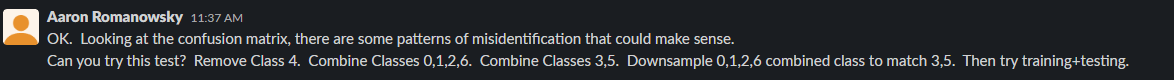

In [18]:
def replace(df, ind):
    label = list(df['labels'])[0]
    newDf = df.replace(label, str(ind))
    return(newDf)

In [19]:
# combined 3 and 5
second = pd.concat([
                    replace(likely_dE_ETGcluster, 1), # old 3
                    replace(poss_dE_ETGcluster, 1) # old 5
                    ])
# combine 0,1,2,6
first = pd.concat([replace(clusterBG_LTG, 0), # old 0
                   replace(BG_ETG, 0), # old 1
                   replace(clusterBG_edgeDisk, 0), # old 2
                   replace(weak_bg, 0) # old 6 
                    ])

lenSecond = len(second.index)
lenFirst = len(first.index)

downSampleDf1 = pd.concat([first.sample(frac = lenSecond/lenFirst), second])

# 0 is background
# 1 is dE/ETGcluster

# Generate Rotation data


In [20]:
file = downSampleDf1['files'].to_numpy()
label = downSampleDf1['labels'].to_numpy()
originalDir = 'SDSS1/'
rotDir = 'rotations'

rotFilenames = list()
rotLabels = list()
for f, l in zip(file, label):
    imgString = originalDir + f
    
    im = PIL.Image.open(imgString)

    angle = 90
    out = im.rotate(angle)
    outString = f'{rotDir}/{f[:-5]}_rot{angle}_label={l}.jpeg'
    dfString = f'{f[:-5]}_rot{angle}_label={l}.jpeg'
    out.save(outString)
    rotFilenames.append(dfString)
    rotLabels.append(l)
    

In [21]:
downSampleDf1

,files,labels
944,sdss_ra=49.4063_dec=41.4087.jpeg,0
5256,sdss_ra=49.9834_dec=41.4553.jpeg,0
1221,sdss_ra=49.4525_dec=41.5851.jpeg,0
364,sdss_ra=49.3081_dec=41.4699.jpeg,0
2350,sdss_ra=49.6199_dec=41.6827.jpeg,0
...,...,...
5338,sdss_ra=49.9932_dec=41.5479.jpeg,1
5357,sdss_ra=49.9947_dec=41.75.jpeg,1
5373,sdss_ra=49.9967_dec=41.3092.jpeg,1
4501,sdss_ra=49.8825_dec=41.7447.jpeg,1


In [22]:
rotationDf90 = pd.DataFrame({'files': rotFilenames ,
                             'labels': rotLabels})
rotationDf90

,files,labels
0,sdss_ra=49.4063_dec=41.4087_rot90_label=0.jpeg,0
1,sdss_ra=49.9834_dec=41.4553_rot90_label=0.jpeg,0
2,sdss_ra=49.4525_dec=41.5851_rot90_label=0.jpeg,0
3,sdss_ra=49.3081_dec=41.4699_rot90_label=0.jpeg,0
4,sdss_ra=49.6199_dec=41.6827_rot90_label=0.jpeg,0
...,...,...
241,sdss_ra=49.9932_dec=41.5479_rot90_label=1.jpeg,1
242,sdss_ra=49.9947_dec=41.75_rot90_label=1.jpeg,1
243,sdss_ra=49.9967_dec=41.3092_rot90_label=1.jpeg,1
244,sdss_ra=49.8825_dec=41.7447_rot90_label=1.jpeg,1


In [23]:
augmentedDataDf = pd.concat([downSampleDf1, rotationDf90])

# Train/Test Split


In [24]:
X = augmentedDataDf['files']
y = augmentedDataDf['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

trainDf = pd.DataFrame({'files' : X_train,
                        'labels': y_train})  
testDf = pd.DataFrame({'files' : X_test,
                        'labels': y_test}) 

trainDf #randomized and split

,files,labels
5427,sdss_ra=50.0051_dec=41.6557.jpeg,0
2020,sdss_ra=49.5791_dec=41.6937.jpeg,1
232,sdss_ra=49.9575_dec=41.6693_rot90_label=1.jpeg,1
3476,sdss_ra=49.7564_dec=41.2183.jpeg,0
3024,sdss_ra=49.7004_dec=41.5288.jpeg,0
...,...,...
5386,sdss_ra=49.9985_dec=41.3856.jpeg,0
24,sdss_ra=49.5268_dec=41.3295_rot90_label=0.jpeg,0
102,sdss_ra=49.6947_dec=41.5876_rot90_label=0.jpeg,0
189,sdss_ra=49.7484_dec=41.4446_rot90_label=1.jpeg,1


# Example Data and Labels:

In [25]:
# img_dir = 'SDSS1'
# fileEx0 = 'sdss_ra=49.2355_dec=41.5722.jpeg'
# galEx0 = load_img(os.path.join(img_dir, fileEx0))
# galEx0

In [26]:
# fileEx1 = 'sdss_ra=49.5028_dec=41.2991.jpeg'
# galEx1 = load_img(os.path.join(img_dir, fileEx1))
# galEx1

In [27]:
# search0 = df1['files']
# search0 = search0.to_list()
# labelEx0 = df1['labels'][search0.index(fileEx0)]
# labelEx1 = df1['labels'][search0.index(fileEx1)]
# print(labelEx0)
# print(labelEx1)

# Create datasets with flow from dataframe

In [28]:
IMG_WIDTH = 200
IMG_HEIGHT = 200

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
# datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDf,
directory="./SDSS2/",
x_col="files",
y_col="labels",
subset="training",
batch_size=1, # divisibility 
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(IMG_WIDTH,IMG_HEIGHT))

validation_generator=datagen.flow_from_dataframe(
dataframe=trainDf,
directory="./SDSS2/",
x_col="files",
y_col="labels",
subset="validation",
batch_size=1,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(IMG_WIDTH,IMG_HEIGHT))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=testDf,
directory="./SDSS2/",
x_col="files",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 238 validated image filenames belonging to 2 classes.
Found 79 validated image filenames belonging to 2 classes.
Found 157 validated image filenames.


C:\Users\Jason\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 12 invalid image filename(s) in x_col="files". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Jason\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 12 invalid image filename(s) in x_col="files". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Jason\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 6 invalid image filename(s) in x_col="files". These filename(s) will be ignored.
  warnings.warn(


In [29]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
#         Dropout(0.5),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
#         Dropout(0.5),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=2, activation='softmax')
    ])
    
    return model

In [30]:
cnn_model = create_model()
# print(cnn_model.summary())
n_epochs = 100
BATCH_SIZE = 1

#### **a. Reduce Learning Rate on Plateau**

Is used to reduce the learning rate when a metric has stopped improving.

In [31]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [32]:
# cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


#### **v. Training the Model**

In [33]:
history = cnn_model.fit(train_generator, 
                        epochs=n_epochs, 
                        validation_data=validation_generator,
                        verbose=2,
                        callbacks=[reduce_lr])

Epoch 1/100
238/238 - 4s - loss: 7.0360 - accuracy: 0.6471 - val_loss: 1.7955 - val_accuracy: 0.4684
Epoch 2/100
238/238 - 1s - loss: 3.5730 - accuracy: 0.6429 - val_loss: 0.8744 - val_accuracy: 0.6709
Epoch 3/100
238/238 - 1s - loss: 0.8876 - accuracy: 0.7731 - val_loss: 4.5897 - val_accuracy: 0.5823
Epoch 4/100
238/238 - 1s - loss: 0.7829 - accuracy: 0.7689 - val_loss: 6.5514 - val_accuracy: 0.6329
Epoch 5/100
238/238 - 1s - loss: 0.5129 - accuracy: 0.8235 - val_loss: 6.0385 - val_accuracy: 0.6456
Epoch 6/100
238/238 - 1s - loss: 0.3816 - accuracy: 0.8445 - val_loss: 6.3843 - val_accuracy: 0.6582
Epoch 7/100
238/238 - 1s - loss: 0.4499 - accuracy: 0.8319 - val_loss: 7.6470 - val_accuracy: 0.6582
Epoch 8/100
238/238 - 1s - loss: 0.3728 - accuracy: 0.8361 - val_loss: 12.1237 - val_accuracy: 0.6203
Epoch 9/100
238/238 - 1s - loss: 0.2491 - accuracy: 0.8950 - val_loss: 12.5153 - val_accuracy: 0.6329
Epoch 10/100
238/238 - 1s - loss: 0.2355 - accuracy: 0.9034 - val_loss: 11.4339 - val_acc

Epoch 81/100
238/238 - 1s - loss: 0.0652 - accuracy: 0.9790 - val_loss: 18.8975 - val_accuracy: 0.6329
Epoch 82/100
238/238 - 1s - loss: 0.0610 - accuracy: 0.9832 - val_loss: 18.3210 - val_accuracy: 0.6456
Epoch 83/100
238/238 - 1s - loss: 0.0620 - accuracy: 0.9748 - val_loss: 19.0389 - val_accuracy: 0.6329
Epoch 84/100
238/238 - 1s - loss: 0.0589 - accuracy: 0.9748 - val_loss: 16.9279 - val_accuracy: 0.6456
Epoch 85/100
238/238 - 1s - loss: 0.0791 - accuracy: 0.9622 - val_loss: 18.0378 - val_accuracy: 0.6329
Epoch 86/100
238/238 - 1s - loss: 0.0710 - accuracy: 0.9874 - val_loss: 17.8826 - val_accuracy: 0.6456
Epoch 87/100
238/238 - 1s - loss: 0.0580 - accuracy: 0.9790 - val_loss: 20.3181 - val_accuracy: 0.6329
Epoch 88/100
238/238 - 1s - loss: 0.0715 - accuracy: 0.9706 - val_loss: 16.2864 - val_accuracy: 0.6456
Epoch 89/100
238/238 - 1s - loss: 0.0747 - accuracy: 0.9706 - val_loss: 18.9563 - val_accuracy: 0.6329
Epoch 90/100
238/238 - 1s - loss: 0.0634 - accuracy: 0.9706 - val_loss: 1

In [34]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

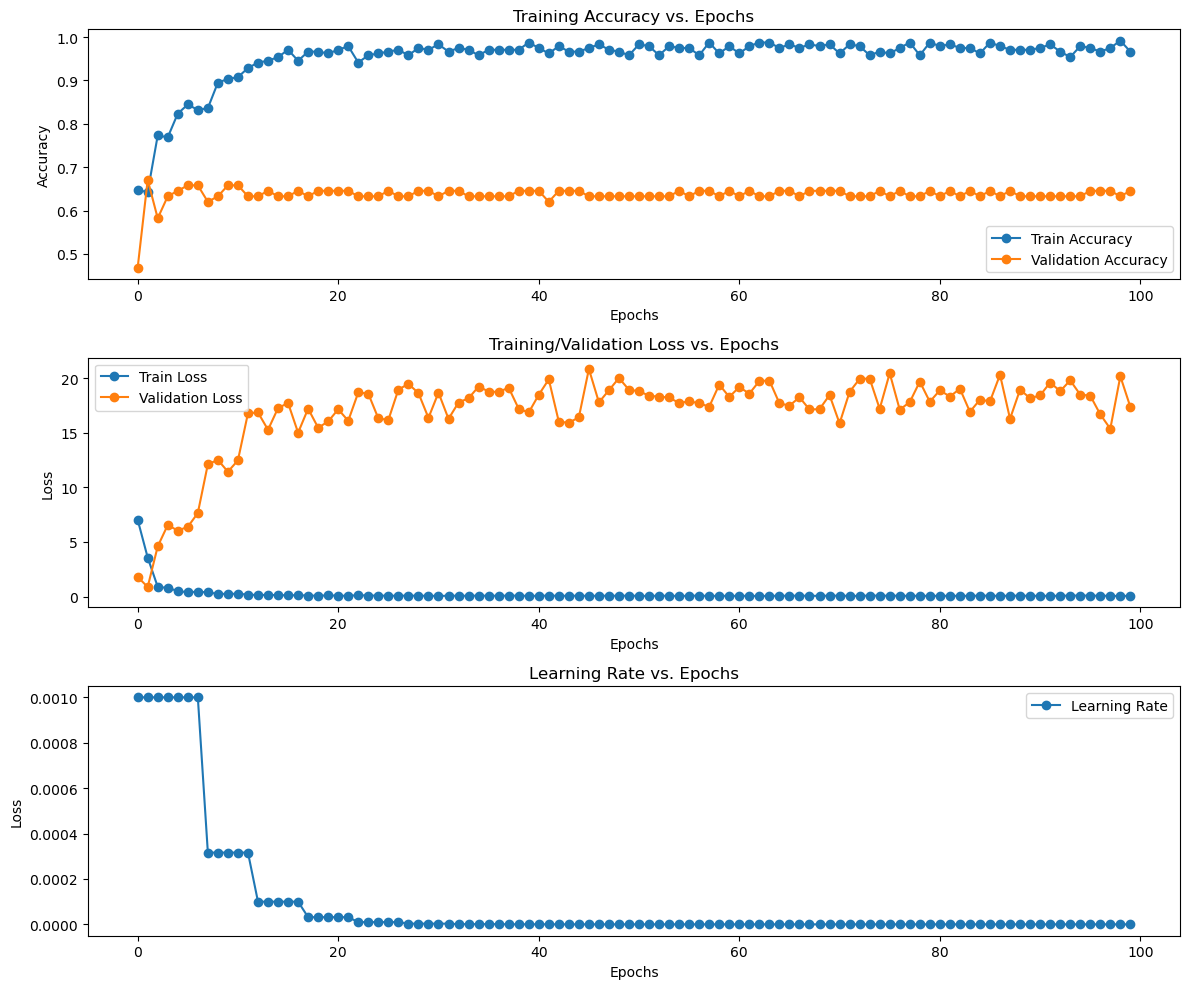

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [36]:
predictions = cnn_model.predict(test_generator)

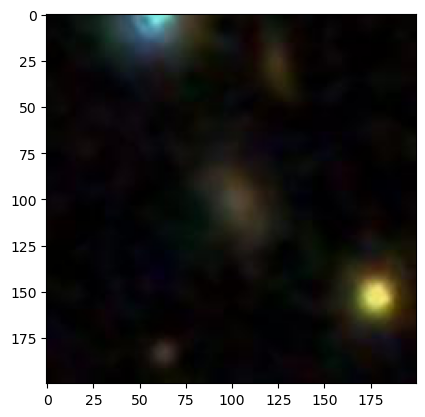

In [37]:
img0 = test_generator[2][0]
plt.figure()
plt.imshow(img0)
plt.show()

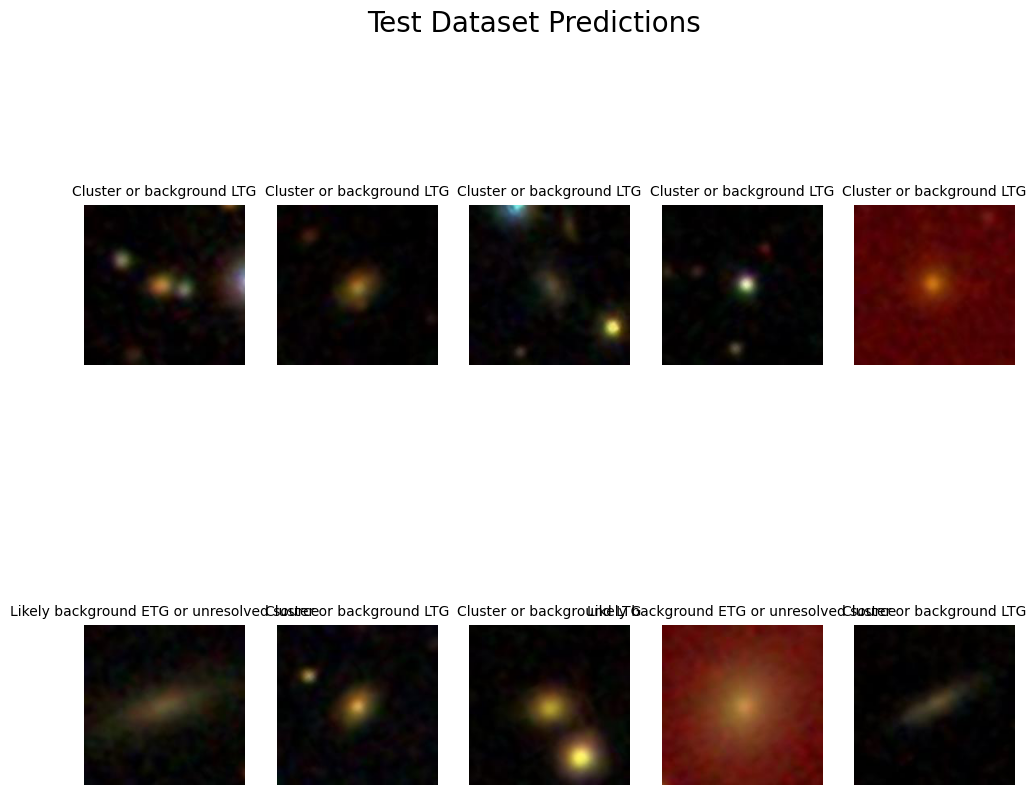

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = unique_labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}", fontsize=10)
        ax[i, j].imshow(test_generator[idx][0])
        
        ax[i, j].axis("off")
        idx += 1

# plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [39]:
test_loss, test_accuracy = cnn_model.evaluate(validation_generator, batch_size=BATCH_SIZE)

79/79 [==============================] - 0s 2ms/step - loss: 17.3675 - accuracy: 0.6456


In [40]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     17.367509841918945
Test Accuracy: 0.6455696225166321


In [41]:
y_pred = np.argmax(predictions, axis=1)
y_true = testDf['labels']
y_true = y_true.tolist()


In [42]:
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0], dtype=int64)

In [43]:
unique_labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in unique_labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : 0
1 : 1


In [44]:
# function to return key for any value
def get_key(val):
    for key, value in unique_labels.items():
        if val == value:
            return key
 
    return "key doesn't exist"

Y_true = []
for i in range(len(y_true)):
    Y_true.append(get_key(y_true[i]))

In [45]:
cf_mtx = confusion_matrix(Y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (12, 10))
# sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
#            cmap="YlGnBu", fmt="", annot=box_labels)
sns.heatmap(cf_mtx,cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [163, 157]

In [46]:
y_true = np.array([int(x) for x in y_true]) # cast to np array for type consistency with y_pred
errors = (y_true - y_pred != 0) # everywhere the numbers don't match
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

ValueError: operands could not be broadcast together with shapes (163,) (157,) 

In [ ]:
test_images = test_generator.filenames
test_img_err = np.asarray(test_images)[errors]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img_err))
        true_index = y_true_errors[idx]
        true_label = unique_labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = unique_labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        ax[i, j].imshow(test_generator[idx][0])
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [ ]:
hits = (y_true - y_pred == 0)
y_true_hits = y_true[hits]
y_pred_hits = y_pred[hits]

In [ ]:
test_img_hits = np.asarray(test_images)[hits]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img_hits))
        true_index = y_true_hits[idx]
        true_label = unique_labels[true_index]
        predicted_index = y_pred_hits[idx]
        predicted_label = unique_labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        ax[i, j].imshow(test_generator[idx][0])
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('True Predictions made on test set', fontsize=20)
plt.show()

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [ ]:
image, label = next(iter(train_generator))
image = image[0]
label = label[0]
rotated = tf.image.rot90(image)
visualize(image, rotated)